# Fiat Accompli Sortition for Leios
This notebook is best viewed at https://nbviewer.org/.

## Require libraries

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Read epoch stake data

The following query on `cardano-db-sync` was used to fetch epoch stake data:

```sql
create temporary table stake_distribution as
select
    epoch_no                  as "Epoch"
  , encode(hash_raw, 'hex')   as "Pool"
  , sum(amount)               as "Stake [Lovelace]"
  , sum(amount) / total_stake as "Stake [Fraction]"
  from epoch_stake
  inner join pool_hash
    on epoch_stake.pool_id = pool_hash.id
  inner join (
    select epoch_no, sum(amount) as total_stake
      from epoch_stake
      group by epoch_no
  ) stake_total
    using (epoch_no)
  where epoch_no < (select max(epoch_no) from epoch_stake)
  group by epoch_no, hash_raw, total_stake
;

\copy stake_distribution to 'stake_distribution.csv' csv header
```

Read the stake distribution data.

In [2]:
stakeDistribution <-
    fread({
        if (file.exists("stake_distribution.csv")) 
            "stake_distribution.csv"
        else
            "http://ipfs.io/ipfs/QmauaDo8ZvDRsjfBj8kTctAXKWtQXmon3F4XeaviSELosS"
    })[order(`Epoch`, `Stake [Lovelace]`)][`Stake [Lovelace]` > 0]
stakeDistribution %>% summary

     Epoch           Pool           Stake [Lovelace]         
 Min.   :210.0   Length:868485      Min.   :             16  
 1st Qu.:313.0   Class :character   1st Qu.:     2342124049  
 Median :385.0   Mode  :character   Median :   152289051568  
 Mean   :384.9                      Mean   :  8550462693311  
 3rd Qu.:460.0                      3rd Qu.:  4564051545920  
 Max.   :535.0                      Max.   :486514766981074  
 Stake [Fraction]   
 Min.   :0.000e+00  
 1st Qu.:1.010e-07  
 Median :6.647e-06  
 Mean   :3.754e-04  
 3rd Qu.:1.978e-04  
 Max.   :3.107e-02  

Use the most recent epoch.

In [3]:
lastEpoch <- stakeDistribution[, max(`Epoch`)]
lastEpoch

[1] 535

Make a note of the number of active stake pools.

In [4]:
nPools <- stakeDistribution[`Epoch` == lastEpoch, .N]
nPools

[1] 2792

## Stake distribution by epoch

### Plot the stake distribution

The stake distribution does not change much over the epochs.

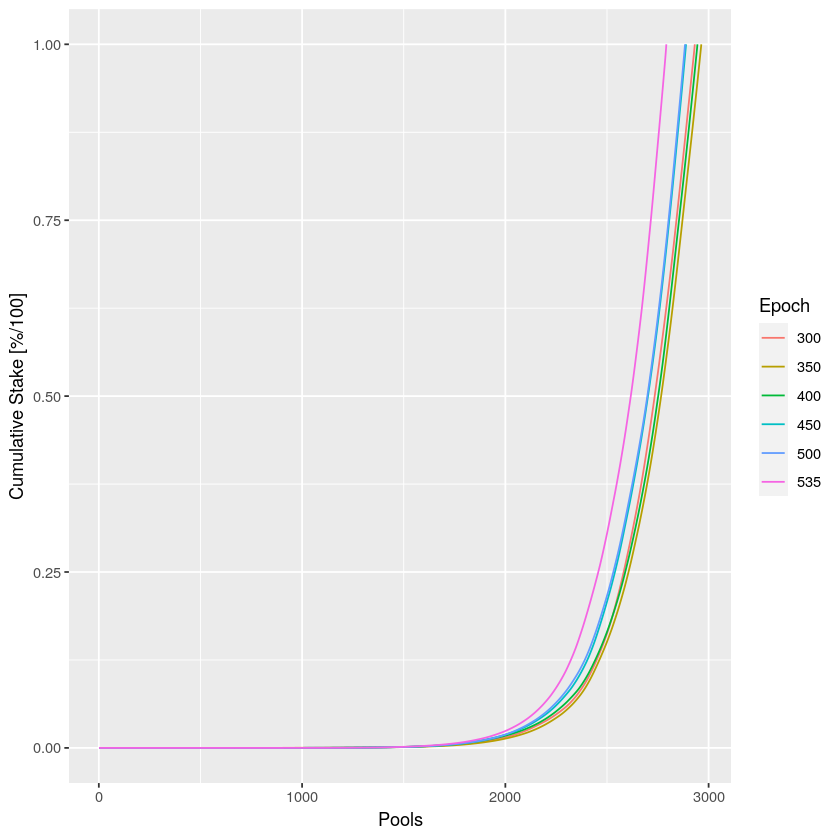

In [5]:
ggplot(
    stakeDistribution[
        `Epoch` %in% c(300,350,400,450,500,lastEpoch),
        .(`Pools`=rank(.I), `Cumulative Stake [%/100]`=cumsum(`Stake [Fraction]`)),
        by=.(`Epoch`=factor(`Epoch`))
    ],
    aes(x=`Pools`, y=`Cumulative Stake [%/100]`, color=`Epoch`)
) +
  geom_line()

### Fit to stake distribution

It turns out that a beta distribution with $\alpha = 11$ and $\beta = 1$ is a good fit to the cumulative distribution of stake.

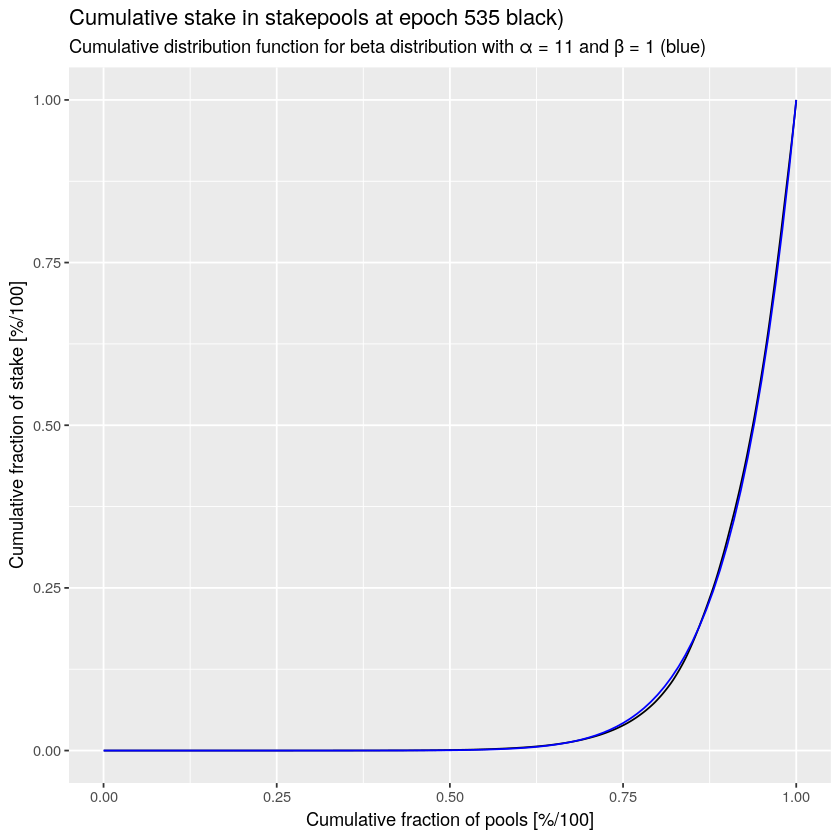

In [6]:
ggplot(
    stakeDistribution[
        `Epoch` == lastEpoch,
        .(`Pools`=rank(.I)/nPools, `Cumulative Stake [%/100]`=cumsum(`Stake [Fraction]`)),
        by=.(`Epoch`=factor(`Epoch`))
    ],
    aes(x=`Pools`, y=`Cumulative Stake [%/100]`)
) +
  geom_line() +
  geom_line(data=data.table(x=0:100/100, y=pbeta(0:100/100, 11, 1)), aes(x=x, y=y), color="blue") +
  xlab("Cumulative fraction of pools [%/100]") +
  ylab("Cumulative fraction of stake [%/100]") +
  ggtitle(
      paste("Cumulative stake in stakepools at epoch", lastEpoch, "black)"),
      subtitle="Cumulative distribution function for beta distribution with α = 11 and β = 1 (blue)"
      )

### Compare the stake distribution to the inverse of the committee size

This plot provides an assessment of how many SPO block-producing nodes will almost always be in every randomly-selected committee.

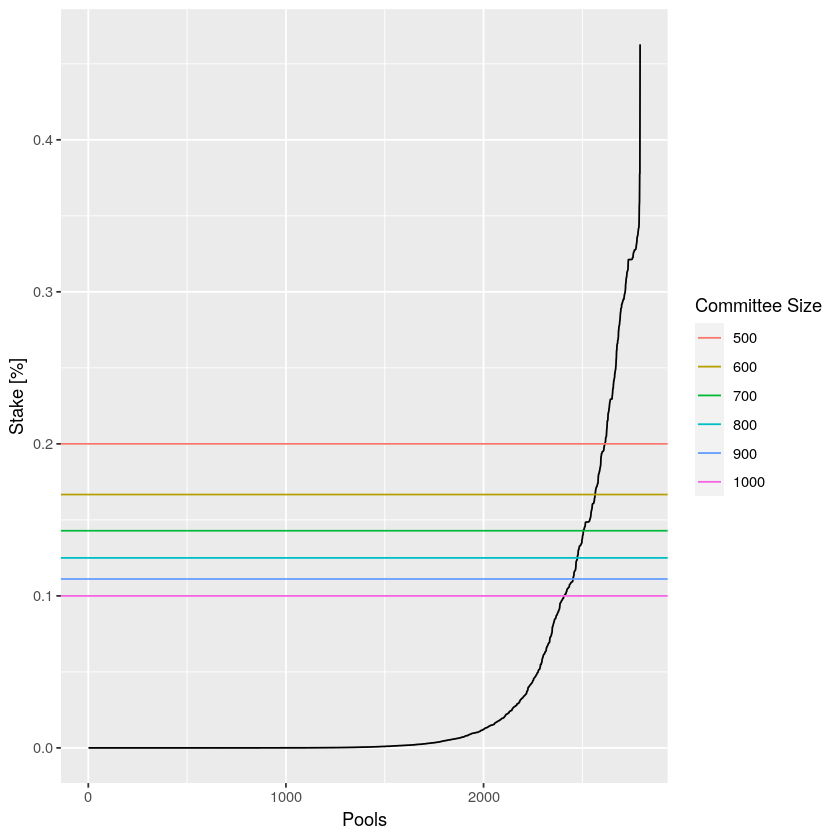

In [7]:
ggplot(
    stakeDistribution[
        `Epoch` == lastEpoch,
        .(`Pools`=rank(.I), `Stake [%]`=100*`Stake [Fraction]`),
    ],
    aes(x=`Pools`, y=`Stake [%]`)
) +
  geom_line() +
  geom_hline(data=CJ(`h`=5:10*100)[, .(`Threshold`=1/`h`, `Committee Size`=factor(`h`))], aes(yintercept=100*`Threshold`, color=`Committee Size`))

## Fiat accompli sortition

We start with the stake distribution $S$, ordered by decreasing stake.

In [8]:
S <- stakeDistribution[`Epoch` == lastEpoch][order(-`Stake [Fraction]`)][, `Stake [Fraction]`]

The quantity $\rho$ is the cumulative sum of $S$, starting from the *smallest* stake.

In [9]:
ρ <- rev(cumsum(rev(S)))

## Scheme FA1<sup>F</sup>

The unweighted scheme FA1<sup>F</sup> (of Figure 4) creates persistent seats for voters having at least $1 / n$ of the stake, where $n$ is the committee size.

In [10]:
FA1 <- function(n) {
    nSflat <- floor(S * n)
    list(
        `Persistent Voters` = (which(nSflat == 0) - 1)[1],
        `Persistent Votes` = sum(nSflat)
    )

}    

## Scheme wFA<sup>F</sup>

The weighted scheme wFA<sup>F</sup> creates persistent voters until a particular inequality fails to be satisfied.

In [11]:
wFA <- function(n) {
    i <- 1:n
    iStar <- which(
        ((1 - S / ρ)^2)[1:n] >= (n - i) / (n - i + 1)
    )[1]
    list(
        `Persistent Voters` = iStar - 1,
        `Persistent Votes` = n * (1 - ρ[iStar])
    )
}

## Comparison of wFA<sup>F</sup> and FA1<sup>F</sup>

In [12]:
results <- CJ(`Committee Size`=1:1000, `Scheme`=c("FA1", "wFA"))
results[`Scheme` == "FA1", 
    c("Persistent Voters", "Persistent Votes"):=mapply(FA1, `Committee Size`),
    by=.(`Committee Size`)
]
results[`Scheme` == "wFA", 
    c("Persistent Voters", "Persistent Votes"):=mapply(wFA, `Committee Size`),
    by=.(`Committee Size`)
]

### Number of persistent voters

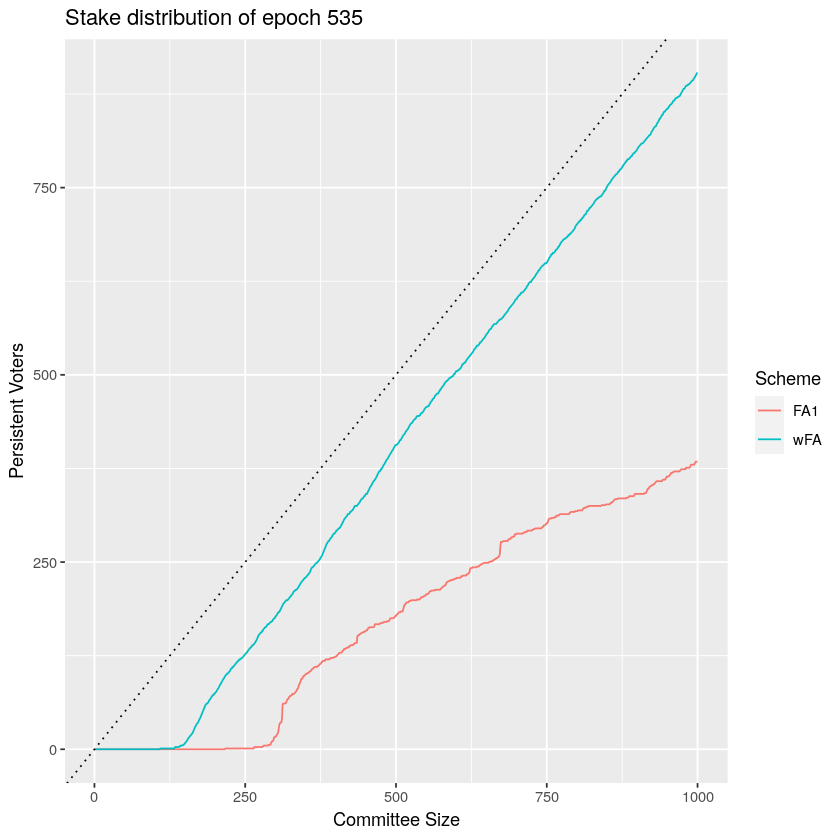

In [13]:
ggplot(results, aes(x=`Committee Size`, y=`Persistent Voters`, color=`Scheme`)) +
  geom_line() +
  geom_abline(intercept=0, slope=1, linetype="dotted") +
  ggtitle(paste("Stake distribution of epoch", lastEpoch))

In [14]:
ggsave("fiat-accompli-voters.png", width=8, height=6, units="in", dpi=150)

In [15]:
ggsave("fiat-accompli-voters.svg", width=8, height=6, units="in", dpi=150)

### Number of votes by the persistent voters

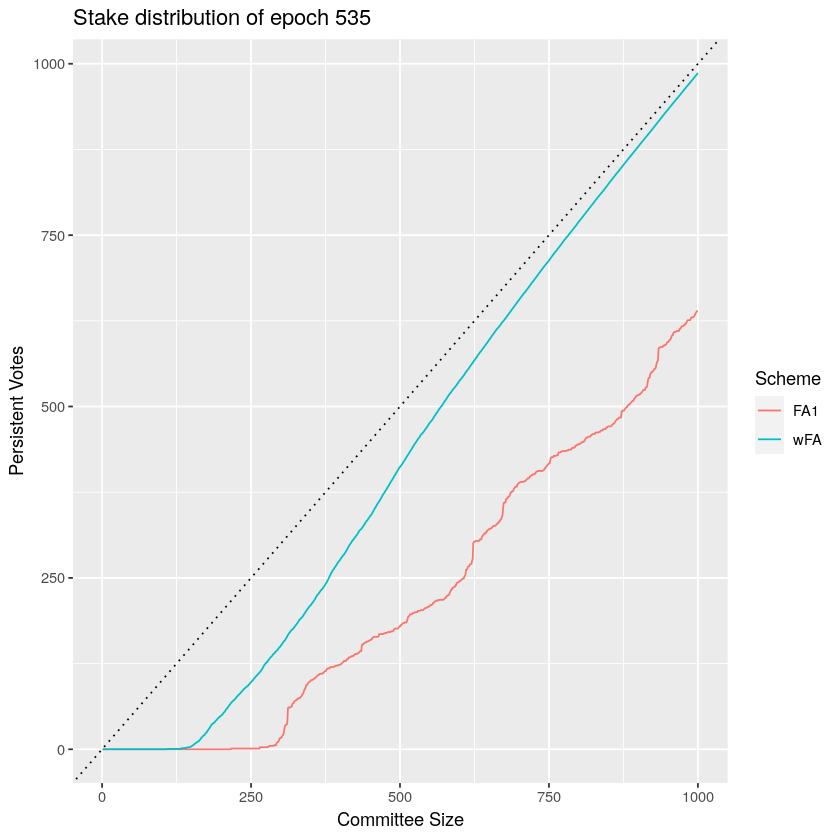

In [16]:
ggplot(results, aes(x=`Committee Size`, y=`Persistent Votes`, color=`Scheme`)) +
  geom_line() +
  geom_abline(intercept=0, slope=1, linetype="dotted") +
  ggtitle(paste("Stake distribution of epoch", lastEpoch))

In [17]:
ggsave("fiat-accompli-votes.png", width=8, height=6, units="in", dpi=150)

In [18]:
ggsave("fiat-accompli-votes.svg", width=8, height=6, units="in", dpi=150)

## Committee size

Consider the committee size $n$, which contains $m$ persistent voters.

The certificate must contain the following information:

- Common to all votes
    - Election ID: Presumably a 32-byte identifier for the Leios election is included in the certificate, though perhaps this is not strictly necessary.
    - Message: the 32-byte hash of the block being endorses is also included in the certificate.
- Identity of voters
    - Persistent voters are encoded in a bitset of size $m$, occupying $\left\lceil m / 8 \right\rceil$.
    - Non-persistent voters are encoded by their Pool ID (or equivalent), occupying 32 bytes each and hence $32 \cdot (n - m)$ bytes total.
- Eligibility proof
    - Persistent voters are eligible by definition, so no proof is needed.
    - Non-persistent voters prove eligibility with a 96-byte BLS signature (as defined the the Leios paper), occupying $96 \cdot (n - m)$ bytes total.
- Aggegrate signatures
    - Signed message (ASig in the Leios paper): The aggregate BLS signature on the message is 96 bytes.
    - Signed election proofs (BSig in the Leios paper): Perhaps not strictly necessary, but another 96 byte BLS signature can attest to the proof of the eligibility.
    
Thus the total certificate size is

$$
\text{certificate bytes} = 258 + \left\lceil \frac{m}{8} \right\rceil + 128 \cdot (n - m)
$$

which includes the extra tbyte word necessary for encoding a list in CBOR.

Note that this certificate size presumes that the following information is available outside of the certificate, via key registration etc.

- BLS public keys for each active Pool ID
    - Approximately 3000 pools
    - Pool ID is 32 bytes
    - BLS key is 192 bytes
    - A KES signature on this information is 448 bytes
- Stake held by each Pool ID: up to 8 bytes

The total of size of data outside of the certificate is approximately $3000 \cdot (32 + 192 + 8 + 448) = 2,040,000$ bytes. It is not decided how frequently the new BLS keys will be registered.

In [19]:
certSize <- function(n, m)
    258 + ceiling(m / 8) + 128 * (n - m)

### Certificate size for Fiat Accompli

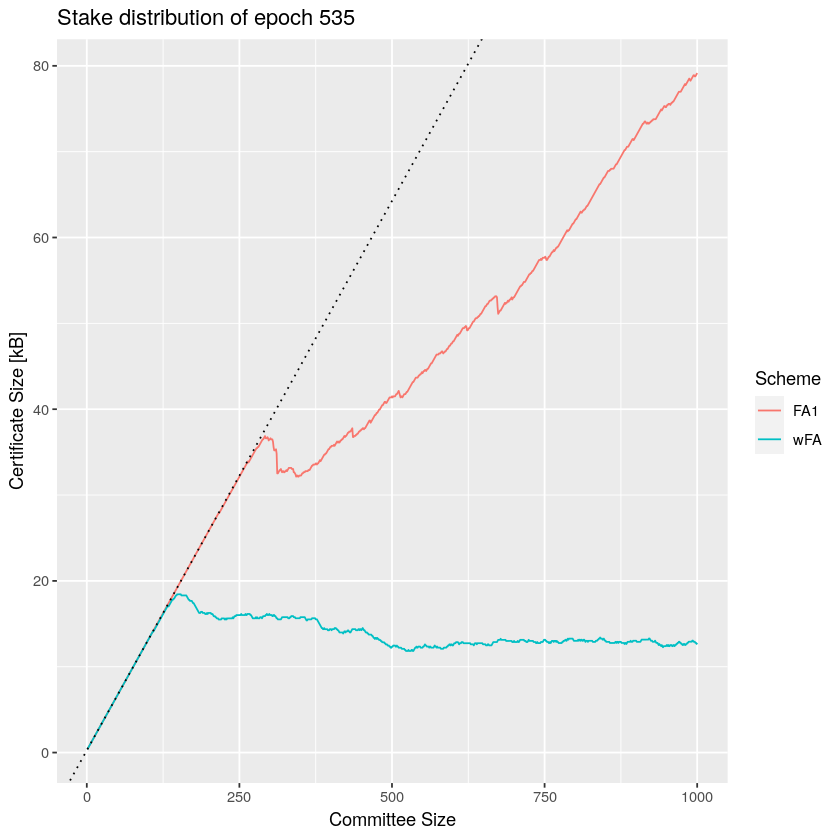

In [20]:
ggplot(results, aes(x=`Committee Size`, y=mapply(certSize, `Committee Size`, `Persistent Voters`)/1000, color=`Scheme`)) +
  geom_line() +
  geom_abline(intercept=0.258, slope=0.128, linetype="dotted") +
  ylab("Certificate Size [kB]") +
  ggtitle(paste("Stake distribution of epoch", lastEpoch))

In [21]:
ggsave("fiat-accompli-cert.png", width=8, height=6, units="in", dpi=150)

In [22]:
ggsave("fiat-accompli-cert.svg", width=8, height=6, units="in", dpi=150)

## <font color="red">WORK IN PROGRESS</font>

In [ ]:
dwFA <- function(n) {
    k <- length(S)
    i <- 1:n
    iStar <- which( ((1 - S / rho)^2)[1:n] >= (n - i) / (n - i + 1) )[1]
    n1 <- iStar - 1
    n2 <- n - n1
    rho0 <- rho[iStar]
    if (n1 == 0)
        list(n1 = 0, n2 = n2, w1 = c(), p2 = S, w2 = rep(1 / n, k))
    else
        list(n1 = n1, n2 = n2, w1 = head(S, n1), p2 = tail(S, - n1) / rho0, w2 = rep(rho0 / n2, k - n1))
}

In [ ]:
sum(dwFA(500)$w1) + dwFA(500)$n2 * sum(dwFA(500)$p2 * dwFA(500)$w2)

In [ ]:
adv <- function(padv, pw) {
    advmask <- rbinom(S %>% length, 1, padv) == 1
    w <- c(
        pw$w1,
        apply(rmultinom(pw$n2, 1, pw$p2), 1, sum) * pw$w2
    )
    list(
        `Adversarial Stake [%]` = 100 * sum(S[advmask]),
        `Adversarial Committee [%]` = 100 * sum(w[advmask]) / sum(w),
        `Committee Size` = length(which(w > 0))
    )
}

In [ ]:
adv2 <- function(padv, pw) {
    advmask <- rbinom(S %>% length, 1, padv) == 1
    w <- c(
        pw$w1,
        apply(rmultinom(pw$n2, 1, pw$p2), 1, sum) * pw$w2
    )
    ssltp <- sum(S[advmask]) < padv
    c(ssltp && sum(w[advmask]) / sum(w) > 0.5, ssltp)
}

In [ ]:
apply(mapply(function(i) adv2(0.49, dwFA(500)), 1:10000), 1, sum) %>% (function(x) x[1]/x[2])

In [ ]:
apply(mapply(function(i) adv2(0.45, dwFA(500)), 1:10000), 1, sum) %>% (function(x) x[1]/x[2])